In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [24]:
%ls

2_week-4-ridge-regression-assignment-1-blank.ipynb
Assig_1_Seattle_housing_regression.ipynb
Lasso_preferred.ipynb
Lasso_preferred_work.ipynb
Matrix Week 2 assignment.ipynb
Overfitting_Demo_Ridge_Lasso.ipynb
Overfitting_Demo_Ridge_Lasso.ipynb copy*
Week 2 assignmnet.ipynb
copy2_week-2-multiple-regression-assignment-1-blank.ipynb
extra_week-1-simple-regression-assignment-blank.ipynb
extra_week-2-multiple-regression-assignment-2-blank.ipynb
house_set_1_data.csv
house_set_2_data.csv
house_set_4_data.csv
house_test_data.csv*
house_train_data.csv*
house_valid_data.csv*
kc_house_data.csv*
kc_house_set_3_data.csv
week-3-polynomial-regression-assignment-blank.ipynb
week-4-ridge-regression-assignment-1-blank.ipynb
week-4-ridge-regression-assignment-2-blank.ipynb
week-5-lasso-assignment-1-blank.ipynb
week-5-lasso-assignment-2-blank.ipynb
week-6-local-regression-assignment-blank.ipynb


In [25]:
train = pd.read_csv('house_train_data.csv')
train.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000


###### Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
###### On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

In [26]:
from math import log, sqrt
train['sqft_living_sqrt'] = train['sqft_living'].apply(sqrt)
train['sqft_lot_sqrt'] = train['sqft_lot'].apply(sqrt)
train['bedrooms_square'] = train['bedrooms']*train['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
train['floors'] = train['floors'].astype(float) 
train['floors_square'] = train['floors']*train['floors']

In [27]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

In [28]:
# Training Set
X_train = train.loc[:, all_features]
y_train = train.loc[:, 'price']

###### Validation

In [29]:
val = pd.read_csv('house_valid_data.csv')
val.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650


In [30]:
#New Features for Validation set
from math import log, sqrt
val['sqft_living_sqrt'] = val['sqft_living'].apply(sqrt)
val['sqft_lot_sqrt'] = val['sqft_lot'].apply(sqrt)
val['bedrooms_square'] = val['bedrooms']*val['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
val['floors'] = val['floors'].astype(float) 
val['floors_square'] = val['floors']*val['floors']

In [31]:
# Test Set
X_test = val.loc[:, all_features]
y_test = val.loc[:, 'price']

In [32]:
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (9761, 17)
X_test : (9635, 17)
y_train : (9761,)
y_test : (9635,)


##### Use loc to standardize the data without losing the column names

In [33]:
from sklearn.preprocessing import StandardScaler
# Standardize numerical features
stdSc = StandardScaler()
"""X_train = stdSc.fit_transform(X_train)
X_test = stdSc.transform(X_test)"""
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, all_features] = stdSc.fit_transform(X_train.loc[:, all_features])
X_test.loc[:, all_features] = stdSc.transform(X_test.loc[:, all_features])

##### Log Transform the Target

In [34]:
#Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.
# Log transform the target for official scoring
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

##### RMSE

In [35]:
#Cross Validation Score: RMSE

# Define error measure for official scoring : RMSE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Training RMSE : 0.318183514694
Test RMSE : 0.309018890229


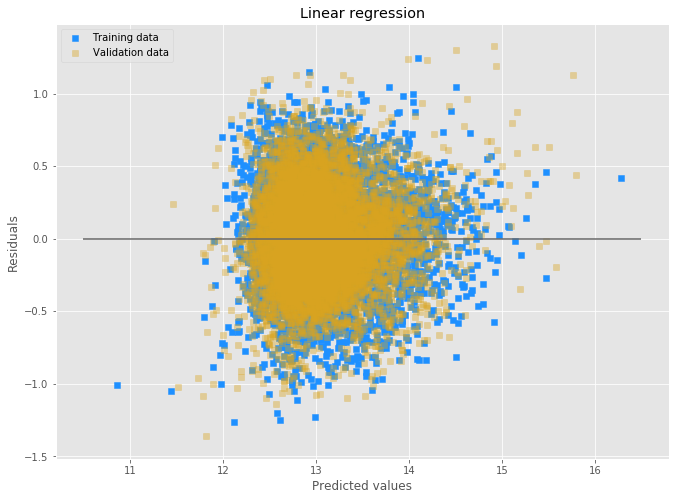

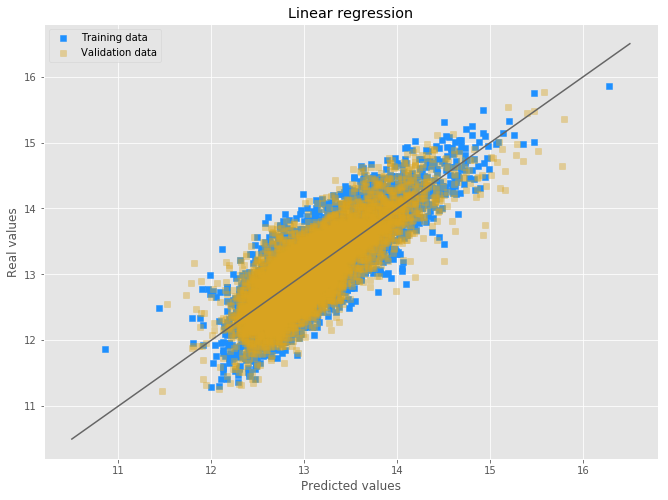

In [36]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("Training RMSE :", rmse_cv_train(lr).mean())
print("Test RMSE :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.figure(figsize=(11,8))
plt.scatter(y_train_pred, y_train_pred - y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha=0.4)
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 16.5, color = "#666666")
plt.show()

# Plot predictions
plt.figure(figsize=(11,8))
plt.scatter(y_train_pred, y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha=0.4)
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 16.5], [10.5, 16.5], c = "#666666")
plt.show()

##### Create Coefficient Matrix

In [37]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + [i for i in all_features]
ind = ["linear", "lasso", "elasticNet"]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)
coef_matrix_simple

,rss,intercept,bedrooms,bedrooms_square,bathrooms,sqft_living,sqft_living_sqrt,sqft_lot,sqft_lot_sqrt,floors,floors_square,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
linear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lasso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elasticNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
models = ["linear", "lasso", "elasticNet"]

#Return the result in pre-defined format
rss = sum((y_train_pred-y_train)**2)
ret = [rss]
ret.extend([lr.intercept_])
ret.extend(lr.coef_)

for i, j in enumerate(ret):
    coef_matrix_simple.iloc[0, i] = j

In [39]:
coef_matrix_simple

,rss,intercept,bedrooms,bedrooms_square,bathrooms,sqft_living,sqft_living_sqrt,sqft_lot,sqft_lot_sqrt,floors,floors_square,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
linear,925.463,13.049,-0.048,0.025,0.046,-0.012,0.224,0.082,-0.091,-0.005,0.043,0.038,0.034,0.023,0.264,-0.015,0.002,-0.165,0.000
lasso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
elasticNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Lasso Regression

In [19]:
l1_penalty_values = np.logspace(1, 7, num=13)
l1_penalty_values

array([  1.00000000e+01,   3.16227766e+01,   1.00000000e+02,
         3.16227766e+02,   1.00000000e+03,   3.16227766e+03,
         1.00000000e+04,   3.16227766e+04,   1.00000000e+05,
         3.16227766e+05,   1.00000000e+06,   3.16227766e+06,
         1.00000000e+07])

Best alpha : 0.001
Lasso RMSE on Training set : 0.313108999086
Lasso RMSE on Test set : 0.309069241544


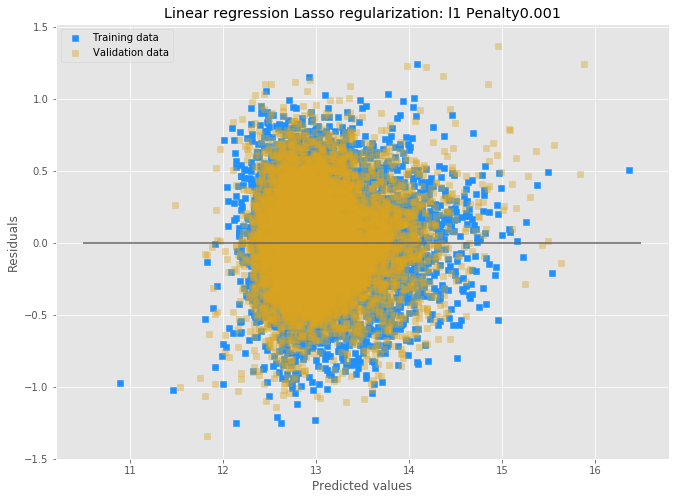

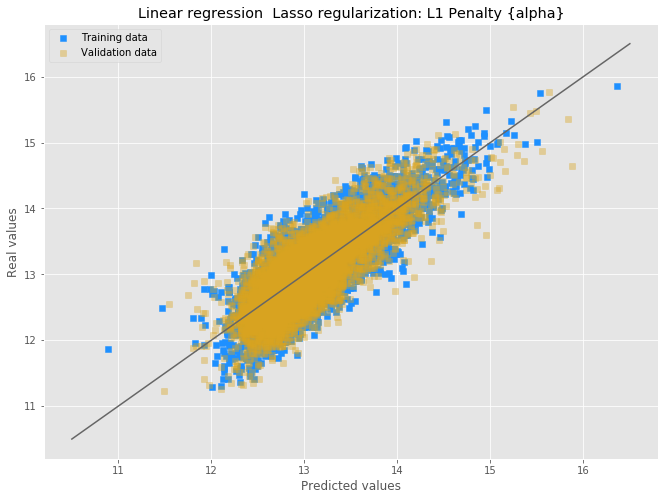

Lasso picked 14 features and eliminated the other 3 features


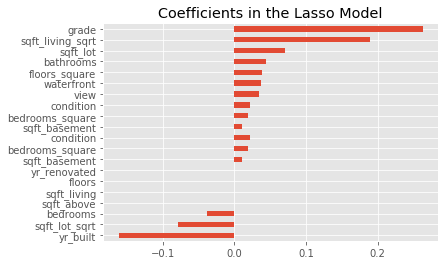

In [40]:

# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3], 
                max_iter = 100_000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)



print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.figure(figsize=(11, 8))
plt.scatter(y_train_las, y_train_las - y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha= 0.4)
plt.title(f"Linear regression Lasso regularization: l1 Penalty{alpha}")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 16.5, color = "#666666")
plt.show()

# Plot predictions
plt.figure(figsize=(11, 8))
plt.scatter(y_train_las, y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha= 0.4)
plt.title("Linear regression  Lasso regularization: L1 Penalty {alpha}")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 16.5], [10.5, 16.5], c = "#666666")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [41]:
#Return the result in pre-defined format
rss = sum((y_train_las-y_train)**2)
retL = [rss]
retL.extend([lasso.intercept_])
retL.extend(lasso.coef_)



for i, j in enumerate(retL):
    coef_matrix_simple.iloc[1, i] = j
    
    
coef_matrix_simple

,rss,intercept,bedrooms,bedrooms_square,bathrooms,sqft_living,sqft_living_sqrt,sqft_lot,sqft_lot_sqrt,floors,floors_square,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
linear,925.463,13.049,-0.048,0.025,0.046,-0.012,0.224,0.082,-0.091,-0.005,0.043,0.038,0.034,0.023,0.264,-0.015,0.002,-0.165,0.000
lasso,926.100,13.049,-0.039,0.019,0.044,0.000,0.189,0.070,-0.079,0.000,0.039,0.038,0.034,0.022,0.263,-0.000,0.011,-0.162,0.000
elasticNet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Best l1_ratio : 0.95
Best alpha : 0.001
Try again for more precision with l1_ratio centered around 0.95
Best l1_ratio : 0.95
Best alpha : 0.001
Now try again for more precision on alpha, with l1_ratio fixed at 0.95 and alpha centered around 0.001
Best l1_ratio : 0.95
Best alpha : 0.001
ElasticNet RMSE on Training set : 0.310368339603
ElasticNet RMSE on Test set : 0.309451275486


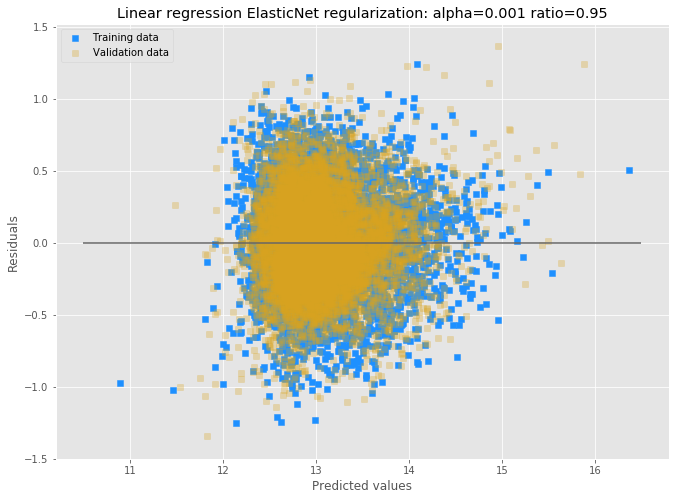

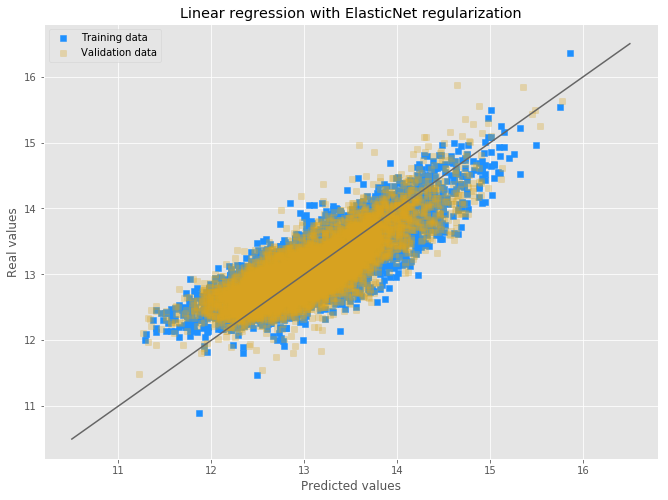

ElasticNet picked 14 features and eliminated the other 3 features


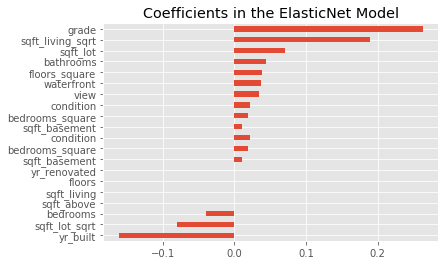

In [42]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.figure(figsize=(11,8))
plt.scatter(y_train_ela, y_train_ela - y_train, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "GoldenRod", marker = "s", label = "Validation data", alpha= 0.3)
plt.title(f"Linear regression ElasticNet regularization: alpha={alpha} ratio={ratio}")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 16.5, color = "#666666")
plt.show()

# Plot predictions
plt.figure(figsize=(11,8))
plt.scatter(y_train, y_train_ela, c = "DodgerBlue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "GoldenRod", marker = "s", label = "Validation data", alpha=0.3)
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 16.5], [10.5, 16.5], c = "#666666")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [43]:
models = ["linear", "lasso", "elasticNet"]


    
#Return the result in pre-defined format
rss = sum((y_train_ela-y_train)**2)
retE = [rss]
retE.extend([elasticNet.intercept_])
retE.extend(elasticNet.coef_)



for i, j in enumerate(retE):
    coef_matrix_simple.iloc[2, i] = j
    
coef_matrix_simple

,rss,intercept,bedrooms,bedrooms_square,bathrooms,sqft_living,sqft_living_sqrt,sqft_lot,sqft_lot_sqrt,floors,floors_square,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
linear,925.463,13.049,-0.048,0.025,0.046,-0.012,0.224,0.082,-0.091,-0.005,0.043,0.038,0.034,0.023,0.264,-0.015,0.002,-0.165,0.000
lasso,926.100,13.049,-0.039,0.019,0.044,0.000,0.189,0.070,-0.079,0.000,0.039,0.038,0.034,0.022,0.263,-0.000,0.011,-0.162,0.000
elasticNet,926.059,13.049,-0.039,0.019,0.044,0.000,0.189,0.071,-0.080,0.000,0.038,0.038,0.034,0.022,0.263,-0.000,0.011,-0.162,0.000


In [44]:
lrTr = rmse_cv_train(lr).mean()
lsTr = rmse_cv_train(lasso).mean()
enTr = rmse_cv_train(elasticNet).mean()

lrTs = rmse_cv_test(lr).mean()
lsTs = rmse_cv_test(lasso).mean()
enTs = rmse_cv_test(elasticNet).mean()



In [45]:
print(f"Training RMSE :{lrTr:.4f}")
print(f"Lasso RMSE on Training set :{lsTr:.4f}")
print(f"ElasticNet RMSE on Training set :{enTr:.4f}")
print("*****" * 10)
print(f"Test RMSE :{lrTs:.4f}")
print(f"Lasso RMSE on Test set :{lsTs:.4f}")
print(f"ElasticNet RMSE on Test set :{enTs:.4f}") 


Training RMSE :0.3182
Lasso RMSE on Training set :0.3131
ElasticNet RMSE on Training set :0.3104
**************************************************
Test RMSE :0.3090
Lasso RMSE on Test set :0.3091
ElasticNet RMSE on Test set :0.3095
